In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import numpy as np
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=40,
                                         shuffle=False, num_workers=2)


classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


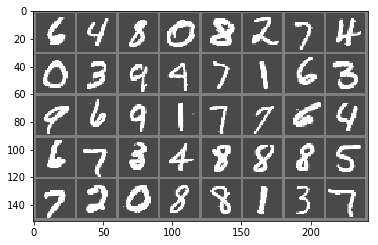

    6     4     8     0


In [25]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def imshow2(img): 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Make model
Define CNN 

In [26]:
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(20, 20, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.fc1 = nn.Linear(20 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 100)

    def forward(self, x):
        # start 1 x 28 x 28
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x, pool_indices_1 = self.pool(x)
        # now 10 x 14 x 14
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x, pool_indices_2 = self.pool(x)
        # now 20 x 7 x 7)
        
        x = x.view(-1, 20 * 7 * 7)
        x = F.relu(self.fc1(x))
        # now 1 x 500
        
        x = F.relu(self.fc2(x))
        # now 1 x 250 
        
        x = self.fc3(x)
        # now 1 x 100
        
        return x, pool_indices_1, pool_indices_2

class Decoder(nn.Module): 
    def __init__(self): 
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(100, 250)
        self.fc2 = nn.Linear(250, 500)
        self.fc3 = nn.Linear(500, 20 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(20, 20, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.ConvTranspose2d(20, 10, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.ConvTranspose2d(10, 10, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.ConvTranspose2d(10, 1, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxUnpool2d(2, 2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, pool_indices_1, pool_indices_2): 
        # start 100
        
        x = self.fc1(x)
        # now 250
        
        x = F.relu(self.fc2(x))
        # now 500
        
        x = F.relu(self.fc3(x))
        # now 20 * 7 * 7
        
        x = x.view(-1, 20, 7, 7)
        # now 20 x 7 x 7
        
        x = self.pool(x, pool_indices_2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # now 10 x 14 x 14
        
        x = self.pool(x, pool_indices_1)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        # now 1 x 28 x 28
        
        # normalize to range -1 to 1 to match input data
        x = self.sigmoid(x)
        x = (x - .75) * 4
        
        return x
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x, pool_1, pool_2 = self.encoder(x)
        x = self.decoder(x, pool_1, pool_2)
        return x
    
net = Net().to(device)

loss function


In [27]:
import torch.optim as optim

criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001,
                             weight_decay=1e-5)

training procedure

In [28]:
from datetime import datetime
last_print = datetime.now()

for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _ = data
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 49 mini-batches
            now = datetime.now()
            elapsed = now - last_print
            last_print = now
            
            print('[%d, %5d] loss: %.3f elapsed seconds: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500, elapsed.total_seconds()))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 0.439 elapsed seconds: 4.146
[1,  1000] loss: 0.356 elapsed seconds: 4.343
[1,  1500] loss: 0.348 elapsed seconds: 3.835
[2,   500] loss: 0.346 elapsed seconds: 4.188
[2,  1000] loss: 0.339 elapsed seconds: 3.976
[2,  1500] loss: 0.336 elapsed seconds: 3.999
[3,   500] loss: 0.334 elapsed seconds: 4.115
[3,  1000] loss: 0.334 elapsed seconds: 4.003
[3,  1500] loss: 0.333 elapsed seconds: 4.031
[4,   500] loss: 0.332 elapsed seconds: 4.041
[4,  1000] loss: 0.330 elapsed seconds: 3.905
[4,  1500] loss: 0.332 elapsed seconds: 4.101
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ACTUAL:


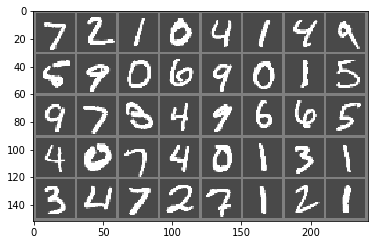

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PREDICTED / GENERATED:


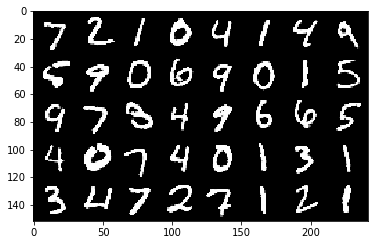

In [30]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = net(images.to(device)).to("cpu").detach()

print("ACTUAL:")
imshow(torchvision.utils.make_grid(images))

print("PREDICTED / GENERATED:") 
imshow2(torchvision.utils.make_grid(outputs))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ACTUAL:


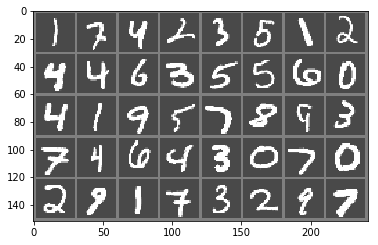

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PREDICTED / GENERATED:


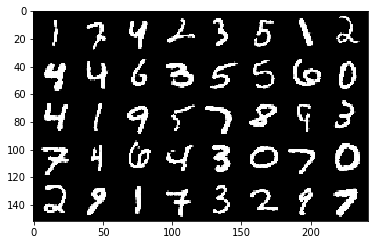

In [31]:
images, labels = dataiter.next()
encoded, pool_1, pool_2 = net.encoder(images.to(device))
decoded = net.decoder(encoded, pool_1, pool_2).to("cpu").detach()

print("ACTUAL:")
imshow(torchvision.utils.make_grid(images))

print("PREDICTED / GENERATED:") 
imshow2(torchvision.utils.make_grid(decoded))